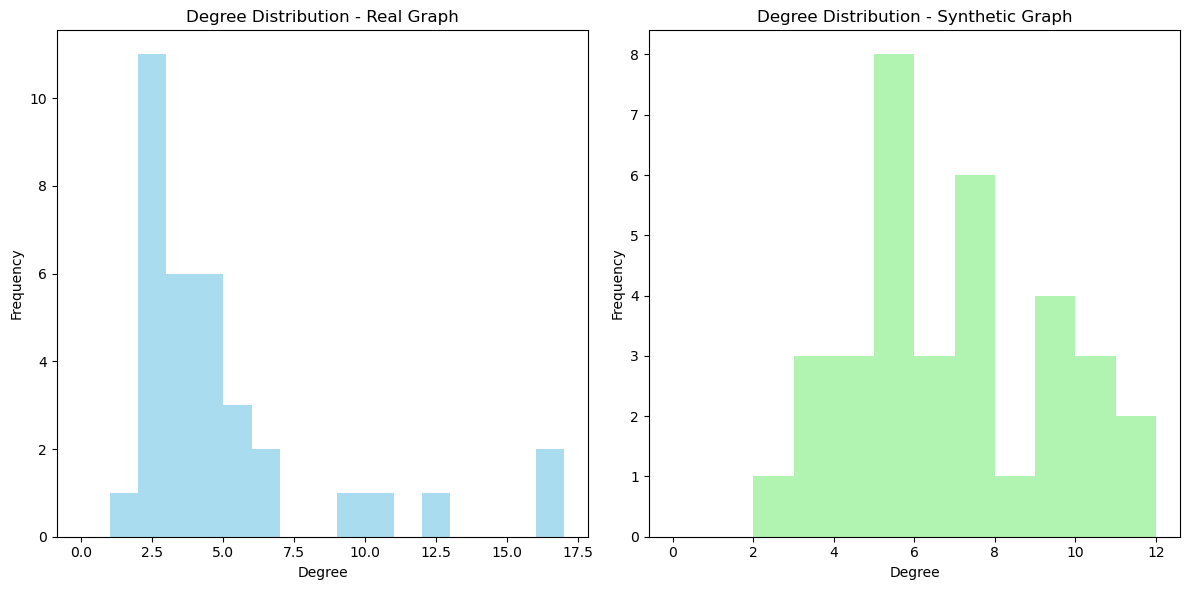

Average Clustering Coefficient - Real Graph: 0.5706384782076823
Average Clustering Coefficient - Synthetic Graph: 0.23103938545115016
Density - Real Graph: 0.13903743315508021
Density - Synthetic Graph: 0.19607843137254902
Assortativity - Real Graph: -0.47561309768461413
Assortativity - Synthetic Graph: -0.05992035987551231


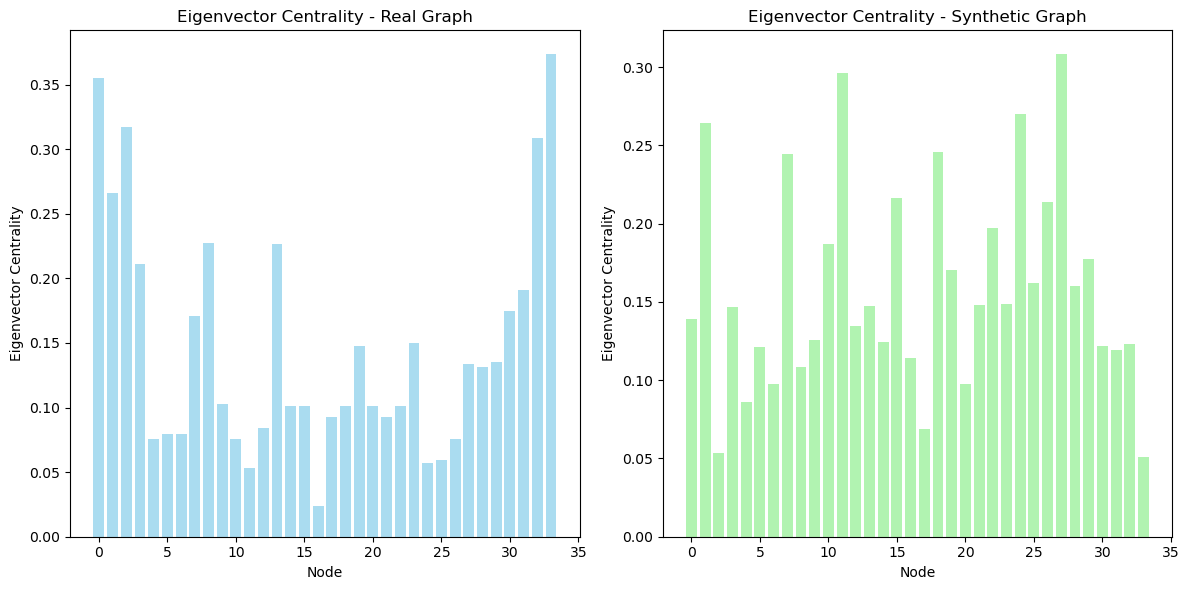

In [48]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Function to apply Ising model dynamics for local refinement
def apply_ising_model(G, temperature=0.5):
    spins = np.random.choice([-1, 1], size=len(G.nodes()))

    # Iterate over edges and update spins based on Ising model dynamics
    for u, v in G.edges():
        energy_change = 2 * spins[u] * spins[v]
        probability = np.exp(-energy_change / temperature)
        if np.random.rand() < probability:
            spins[u] *= -1
            spins[v] *= -1

    # Update edge weights based on spins
    for u, v in G.edges():
        G[u][v]['weight'] = abs(spins[u] * spins[v])

# Function to perform percolation-based sparsification
def perform_percolation(G, threshold):
    # Copy the original graph
    G_sparsified = G.copy()

    # Remove edges based on percolation threshold
    for u, v in list(G_sparsified.edges()):
        if np.random.rand() < threshold:
            G_sparsified.remove_edge(u, v)

    return G_sparsified

# Load a real graph (replace this with your real graph)
G_real = nx.karate_club_graph()

# Generate an initial synthetic graph (e.g., random graph)
G_synthetic = nx.erdos_renyi_graph(len(G_real), 0.2)

# Apply Ising model dynamics for local refinement
apply_ising_model(G_synthetic)

# Determine percolation threshold (example: 20% of edges removed)
percolation_threshold = 0

# Perform percolation-based sparsification
G_synthetic_sparsified = perform_percolation(G_synthetic, percolation_threshold)

# Plot degree distribution for both graphs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(dict(G_real.degree()).values(), bins=range(max(dict(G_real.degree()).values()) + 1), color='skyblue', alpha=0.7)
plt.title('Degree Distribution - Real Graph')
plt.xlabel('Degree')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(dict(G_synthetic_sparsified.degree()).values(), bins=range(max(dict(G_synthetic_sparsified.degree()).values()) + 1), color='lightgreen', alpha=0.7)
plt.title('Degree Distribution - Synthetic Graph')
plt.xlabel('Degree')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Print clustering coefficients
clustering_real = nx.average_clustering(G_real)
clustering_synthetic = nx.average_clustering(G_synthetic_sparsified)
print("Average Clustering Coefficient - Real Graph:", clustering_real)
print("Average Clustering Coefficient - Synthetic Graph:", clustering_synthetic)

# Print density
density_real = nx.density(G_real)
density_synthetic = nx.density(G_synthetic_sparsified)
print("Density - Real Graph:", density_real)
print("Density - Synthetic Graph:", density_synthetic)

# Print assortativity
assortativity_real = nx.degree_assortativity_coefficient(G_real)
assortativity_synthetic = nx.degree_assortativity_coefficient(G_synthetic_sparsified)
print("Assortativity - Real Graph:", assortativity_real)
print("Assortativity - Synthetic Graph:", assortativity_synthetic)

# Plot eigenvector centrality for both graphs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
ev_real = nx.eigenvector_centrality(G_real)
plt.bar(range(len(ev_real)), ev_real.values(), color='skyblue', alpha=0.7)
plt.title('Eigenvector Centrality - Real Graph')
plt.xlabel('Node')
plt.ylabel('Eigenvector Centrality')

plt.subplot(1, 2, 2)
ev_synthetic = nx.eigenvector_centrality(G_synthetic_sparsified)
plt.bar(range(len(ev_synthetic)), ev_synthetic.values(), color='lightgreen', alpha=0.7)
plt.title('Eigenvector Centrality - Synthetic Graph')
plt.xlabel('Node')
plt.ylabel('Eigenvector Centrality')

plt.tight_layout()
plt.show()


In [42]:
import optuna
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# Define intervals for temperature and percolation threshold
temperatures = np.linspace(0.1, 1.0, num=10)  # Example: from 0.1 to 1.0 with 10 values
percolation_thresholds = np.linspace(0.1, 0.9, num=9)  # Example: from 0.1 to 0.9 with 9 values

# Define target labels (clustering coefficient and eigenvector centrality)
y_clustering = np.array([clustering_synthetic] * len(temperatures))  # Assuming clustering_synthetic is calculated from synthetic graph
y_centrality = np.array([list(ev_synthetic.values())] * len(percolation_thresholds))  # Assuming ev_synthetic is calculated from synthetic graph

def objective(trial):
    # Define parameters to optimize
    temperature = trial.suggest_uniform('temperature', 0.1, 1.0)
    percolation_threshold = trial.suggest_uniform('percolation_threshold', 0.1, 0.9)

    # Define features (temperature and percolation threshold)
    X_train = np.array([[temperature, percolation_threshold]])

    # Define MLP architecture
    mlp_clustering = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=1000, random_state=42)
    mlp_centrality = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=1000, random_state=42)

    # Train MLP on clustering coefficient
    mlp_clustering.fit(X_train, y_clustering)

    # Predict clustering coefficient for different temperature and percolation threshold
    y_clustering_pred = mlp_clustering.predict(X_train)

    # Evaluate clustering coefficient prediction
    clustering_loss = mean_squared_error(y_clustering, y_clustering_pred)

    # Train MLP on centrality
    mlp_centrality.fit(X_train, y_centrality)

    # Predict centrality for different temperature and percolation threshold
    y_centrality_pred = mlp_centrality.predict(X_train)

    # Evaluate centrality prediction
    centrality_loss = mean_squared_error(y_centrality, y_centrality_pred)

    # Return the sum of losses as the objective value
    return clustering_loss + centrality_loss

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Get the best parameters
best_temperature = study.best_params['temperature']
best_percolation_threshold = study.best_params['percolation_threshold']

print("Best Temperature:", best_temperature)
print("Best Percolation Threshold:", best_percolation_threshold)


[I 2024-05-12 20:54:30,203] A new study created in memory with name: no-name-24ea2b7a-4954-4815-8c27-0dfa5c799e24
/var/folders/_y/0xw7_0ss0s3f4kfhj9xl96zw0000gn/T/ipykernel_27264/2066841327.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  temperature = trial.suggest_uniform('temperature', 0.1, 1.0)
/var/folders/_y/0xw7_0ss0s3f4kfhj9xl96zw0000gn/T/ipykernel_27264/2066841327.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  percolation_threshold = trial.suggest_uniform('percolation_threshold', 0.1, 0.9)
[W 2024-05-12 20:54:30,204] Trial 0 failed with parameters: {'temperature': 0.8269524271523752, 'percolation_threshold': 0.6989858918462231} because of the following error: ValueError('Found input var

ValueError: Found input variables with inconsistent numbers of samples: [1, 10]